<a href="https://colab.research.google.com/github/gilad-altshuler/Three_Body_RNN/blob/main/notebooks/3_Teacher_Student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import sys, os
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Colab. Cloning repo...")
    !git clone https://github.com/gilad-altshuler/Beyond_Linear_Summation-Three_Body_RNNs.git
    %cd Beyond_Linear_Summation-Three_Body_RNNs
    ROOT = Path(".").resolve()
    while True:
        user_input_path = input("Enter the full path to the runs directory in your Drive (e.g., /content/drive/MyDrive/runs): ")
        if os.path.isdir(user_input_path):
          user_input_path = Path(user_input_path).expanduser().resolve()
          !ln -s "$user_input_path" /content/runs
          break
        else:
          print("Invalid path. Please try again.")
    # Load Arial font
    !wget -O Arial.ttf "https://github.com/matomo-org/travis-scripts/raw/master/fonts/Arial.ttf"

else:
    print("Not running in Colab.")
    ROOT = Path(__file__).resolve().parent.parent
    sys.path.append(str(ROOT))

In [1]:
import torch
import random
from torch import nn
import numpy as np

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
%matplotlib inline
if IN_COLAB:
  fm.fontManager.addfont('Arial.ttf')
  arial_fp = fm.FontProperties(fname='Arial.ttf')
  plt.rcParams['font.family'] = arial_fp.get_name()
else:
  plt.rcParams['font.family'] = 'Arial'
plt.rcParams["font.size"] = 10
import seaborn as sns

import utils
from tasks import K_Bit_Flipflop_task, MultiFate_task, sin_task
from Models import *

In [ ]:
DATA_DIR = ROOT / "data" / "solution_space"
FIG_DIR = ROOT / "notebooks" / "figures"
RUN_DIR = ROOT.parent / "runs" / "train_solution_space"

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
SEED = 3150
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#Teacher-Student forcing

##K-bit Flip-flop task

### Training procedure

###Evaluation

In [ ]:
import copy
from K_Bit_Flipflop_task import evaluate

In [ ]:
def evaluate(model, input, target, teacher_traj=None, rates=False):
    """
    Evaluate the model on the K-Bit Flipflop task.
    :param model: The model to evaluate
    :param input: Input tensor of shape (batch_size, time_steps, K)
    :param target: Target tensor of shape (batch_size, time_steps, K)
    :param teacher_traj: Optional tensor of teacher trajectories for evaluation
    :param rates: Optional If True, apply output nonlinearity to the trajectory
    :return: Tuple of (accuracy, mse error, R2 score, and teacher-student trajectory mse error)
    """
    from sklearn.metrics import r2_score

    model.eval()
    with torch.no_grad():
        prediction, _, trajectory = model(input, None)
        if rates:
            trajectory = model.output_nonlinearity(trajectory)

        acc = accuracy(prediction,target)
        error = torch.nn.functional.mse_loss(prediction, target).item()
        if teacher_traj is not None:
            r2 = np.array([r2_score(trajectory[:,:,i], teacher_traj[:,:,i]) for i in range(trajectory.shape[2])]).mean().item()
            ts_error = torch.nn.functional.mse_loss(trajectory, teacher_traj).item()
            return acc,error,r2,ts_error
        else:
            return acc,error,None,None


def accuracy(prediction,target):
    sign_prediction = prediction.sign()
    acc = (sign_prediction == target).float().mean().item()
    return acc

In [ ]:
DEVICE="cpu"
T = 100
t_ranks = 3
s_ranks = 10
hidden_dim = 30
data_size = 128

criterion = nn.MSELoss().to(DEVICE)
stats = {"rnn":[{"rnn":[-np.inf]*(s_ranks+1),
                 "tbrnn":[-np.inf]*(s_ranks+1)} for r in range(t_ranks+1)],
         "tbrnn":[{"rnn":[-np.inf]*(s_ranks+1),
                 "tbrnn":[-np.inf]*(s_ranks+1)} for r in range(t_ranks+1)]}

accs = copy.deepcopy(stats)
mse_errs = copy.deepcopy(stats)
r2s = copy.deepcopy(stats)
t_s_errs = copy.deepcopy(stats)

for t_rank in range(1,t_ranks+1):
  # generate new data
  input_size=output_size=K=t_rank
  input, target = K_Bit_Flipflop_task.generate_data(data_size,T,K)

  # define teachers
  lr_rnn_teacher = Low_Rank_RNN(input_size, output_size, hidden_dim, rank=t_rank,
                          mode='cont', form='rate',task="FF",noise_std=0.0,
                          tau=0.2, Win_bias=False, Wout_bias=False).to(DEVICE)

  lr_tbrnn_teacher = Low_Rank_TBRNN(input_size, output_size, hidden_dim, rank=t_rank,
                          mode='cont', form='rate',task="FF",noise_std=0.0,
                          tau=0.2, Win_bias=False, Wout_bias=False).to(DEVICE)

  lr_rnn_teacher.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/Teacher-Student/rank_{t_rank}_RNN_on_{K}_Flipflop.pth",map_location=DEVICE))
  lr_tbrnn_teacher.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/Teacher-Student/rank_{t_rank}_TBRNN_on_{K}_Flipflop.pth",map_location=DEVICE))

  teachers = {"rnn":lr_rnn_teacher,"tbrnn":lr_tbrnn_teacher}

  for t_name,teacher in teachers.items():

    teacher_hidden = teacher(input,None)[2].detach().clone()

    for s_rank in range(t_rank,s_ranks+1):
      # define students
      lr_rnn_student = Low_Rank_RNN(input_size, output_size, hidden_dim, rank=s_rank,
                                mode='cont', form='rate',output_nonlinearity=(lambda x: x),task="FF",noise_std=0.0,
                                tau=0.2, Win_bias=False, Wout_bias=False,w_out=torch.nn.Identity().to(DEVICE)).to(DEVICE)

      lr_tbrnn_student = Low_Rank_TBRNN(input_size, output_size, hidden_dim, rank=s_rank,
                                mode='cont', form='rate',output_nonlinearity=(lambda x: x),task="FF",noise_std=0.0,
                                tau=0.2, Win_bias=False, Wout_bias=False,w_out=torch.nn.Identity().to(DEVICE)).to(DEVICE)

      students = {"rnn":lr_rnn_student,"tbrnn":lr_tbrnn_student}

      for s_name,student in students.items():
        if s_name == t_name and s_rank != t_rank:
          continue

        student.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/Teacher-Student/r_{s_rank}_{s_name}_on_r_{t_rank}_{t_name}_task_{K}_Flipflop.pth",map_location=DEVICE))
        student.w_out = copy.deepcopy(teacher.w_out)
        student.output_nonlinearity = teacher.output_nonlinearity

        stats[t_name][t_rank][s_name][s_rank] = evaluate(student,input,target,teacher_hidden)
        (
          accs[t_name][t_rank][s_name][s_rank],
          mse_errs[t_name][t_rank][s_name][s_rank],
          r2s[t_name][t_rank][s_name][s_rank],
          t_s_errs[t_name][t_rank][s_name][s_rank]
        ) = stats[t_name][t_rank][s_name][s_rank]

In [ ]:
models = ["rnn","tbrnn"]
for t in models:
  print(f"Teacher {t}:")
  for rank in range(1,t_ranks+1):
    print(f"\trank {rank}:")
    for s in models:
      threshold = 0.90
      students = np.array(r2s[t][rank][s][rank:])
      if (students > threshold).any():
        min_pass_threshold = (students > threshold).argmax().item()
        min_rank = min_pass_threshold + rank
        r2 = students[min_pass_threshold]
      else:
        min_rank = f">{s_ranks}"
        r2 = students.max()
      print(f"\t\tstudent {s} - min rank: {min_rank}, R2: {r2}")

Teacher rnn:
	rank 1:
		student rnn - min rank: 1, R2: 0.9951443876828173
		student tbrnn - min rank: >10, R2: 0.5953044868358623
	rank 2:
		student rnn - min rank: 2, R2: 0.9997180415051707
		student tbrnn - min rank: >10, R2: 0.8977957060538628
	rank 3:
		student rnn - min rank: 3, R2: 0.999278548461539
		student tbrnn - min rank: 4, R2: 0.9571389108862427
Teacher tbrnn:
	rank 1:
		student rnn - min rank: >10, R2: -1.703983019379259
		student tbrnn - min rank: 1, R2: 0.9982490190181615
	rank 2:
		student rnn - min rank: >10, R2: -1.2604213613112898
		student tbrnn - min rank: 2, R2: 0.9590174656330724
	rank 3:
		student rnn - min rank: >10, R2: -1.4819188602166227
		student tbrnn - min rank: 3, R2: 0.9474435499767911


/tmp/ipython-input-10-808937788.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  _=ax[row][col].legend()


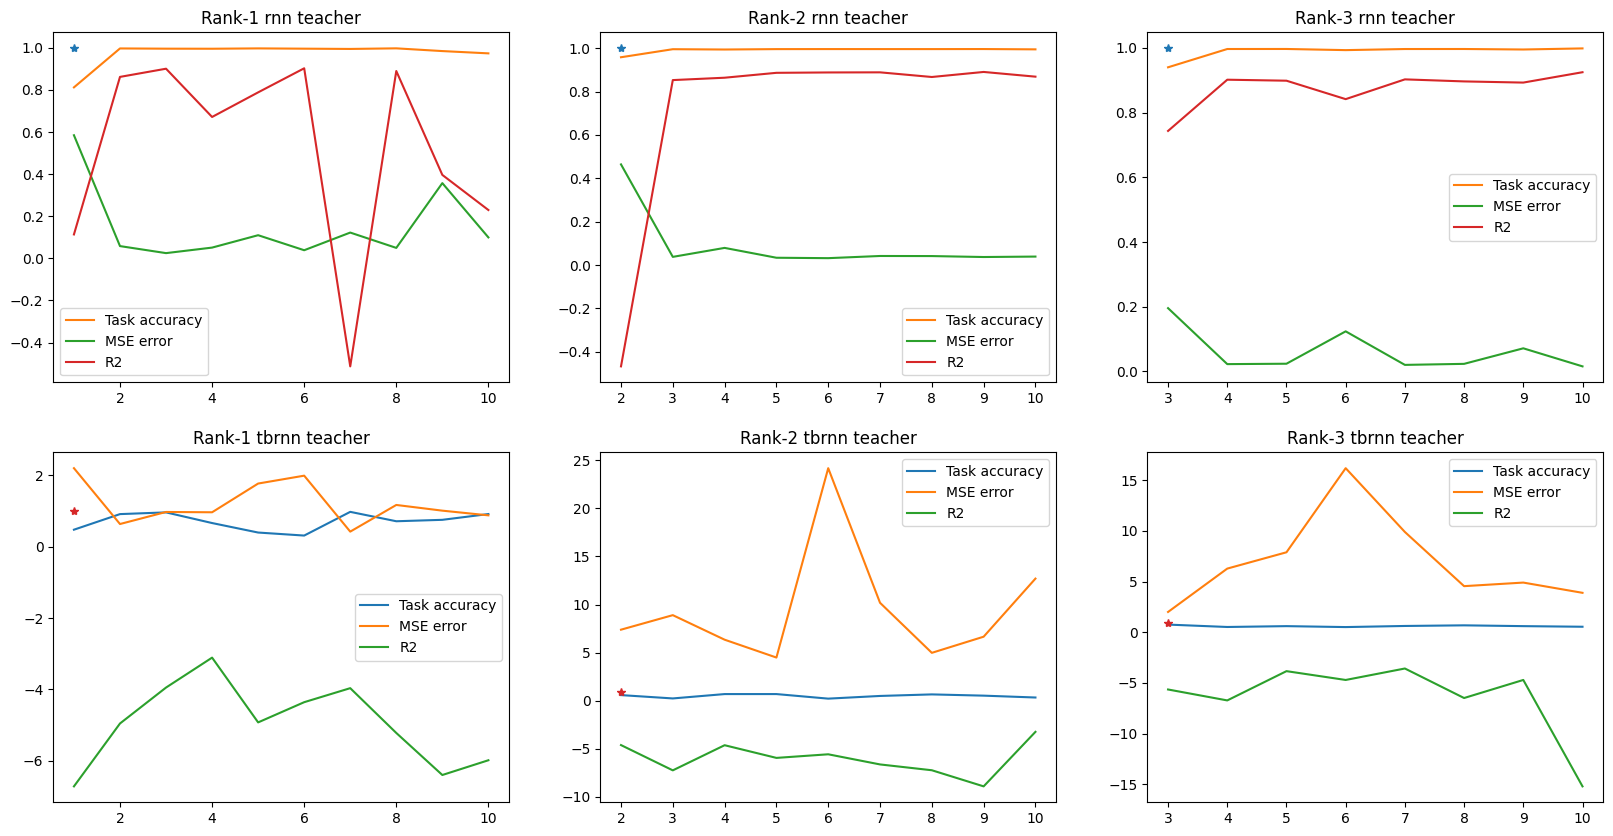

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = fig.subplots(2, 3)
for row,(teacher,t_stat) in enumerate(stats.items()):
  for col,t_r_stat in enumerate(t_stat[1:]):
    for student in t_r_stat.keys():
      t_rank = col + 1
      if teacher!=student:
        ax[row][col].plot(accs[teacher][t_rank][student],label='Task accuracy')
        ax[row][col].plot(mse_errs[teacher][t_rank][student],label='MSE error')
        ax[row][col].plot(r2s[teacher][t_rank][student],label='R2')
      else:
        ax[row][col].plot(r2s[teacher][t_rank][student],'*')

      _=ax[row][col].legend()
      _=ax[row][col].set_title(f"Rank-{t_rank} {teacher} teacher")

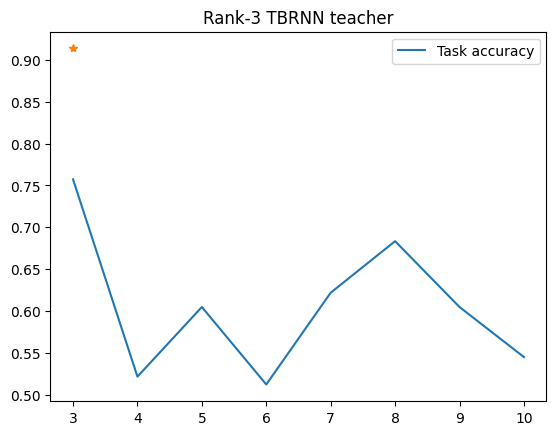

In [ ]:
plt.plot(accs['tbrnn'][3]['rnn'],label='Task accuracy')
# plt.plot(mse_errs['tbrnn'][3]['rnn'],label='MSE error')
# plt.plot(r2s['tbrnn'][3]['rnn'],label='R2')
plt.plot(r2s['tbrnn'][3]['tbrnn'],'*')
_=plt.legend()
_=plt.title(f"Rank-3 TBRNN teacher")

##Sine-wave prediction task

###Training procedure

In [4]:
DEVICE="cpu"
from Models import *
from sin_task import generate_data, evaluate
import copy

T = 100
data_size = 500
input_size = output_size = 1
hidden_dim = 30
t_rank = 2

s_ranks = 6
n_trials = 32

criterion = nn.MSELoss().to(DEVICE)
stats = {
    "rnn": {
        "rnn": [[None for _ in range(n_trials)] for _ in range(s_ranks)],
        "tbrnn": [[None for _ in range(n_trials)] for _ in range(s_ranks)],
    },
    "tbrnn": {
        "rnn": [[None for _ in range(n_trials)] for _ in range(s_ranks)],
        "tbrnn": [[None for _ in range(n_trials)] for _ in range(s_ranks)],
    },
}

t_mse = {
    "rnn": [[None for _ in range(data_size)] for _ in range(n_trials)],
    "tbrnn": [[None for _ in range(data_size)] for _ in range(n_trials)]
}

accs = copy.deepcopy(stats)
mse_errs = copy.deepcopy(stats)
r2s = copy.deepcopy(stats)
t_s_errs = copy.deepcopy(stats)

for run in range(1,n_trials+1):
  print(f"Reading stats of run: {run:03}")
  i = run-1
  input, target = sin_task.generate_data(data_size,T)

  # define teachers
  lr_tbrnn = Low_Rank_TBRNN(input_size, output_size, hidden_dim, rank=t_rank, mode='cont', form='rate', task="Sin",
                      noise_std=0.0, tau=0.2, Win_bias=False, Wout_bias=True).to(DEVICE)
  lr_tbrnn.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/sin_task/{run:03}/tbrnn_teacher.pth",map_location=DEVICE))

  lr_rnn = Low_Rank_RNN(input_size, output_size, hidden_dim, rank=t_rank, mode='cont', form='rate', task="Sin",
                      noise_std=0.0, tau=0.2, Win_bias=False, Wout_bias=True).to(DEVICE)
  lr_rnn.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/sin_task/{run:03}/rnn_teacher.pth",map_location=DEVICE))

  teachers = {"rnn":lr_rnn,"tbrnn":lr_tbrnn}

  for t_name,teacher in teachers.items():
    t_mse[t_name][i],_,_ = evaluate(teacher,input,target,reduction='none')
    teacher_hidden = teacher(input,None)[2].detach().clone()

    for s_rank in range(1,s_ranks+1):
      # define students
      lr_rnn_student = Low_Rank_RNN(input_size, output_size, hidden_dim, rank=s_rank,
                                mode='cont', form='rate',output_nonlinearity=teacher.output_nonlinearity,task="Sin",noise_std=0.0,
                                tau=0.2, Win_bias=False, Wout_bias=True).to(DEVICE)

      lr_tbrnn_student = Low_Rank_TBRNN(input_size, output_size, hidden_dim, rank=s_rank,
                                mode='cont', form='rate',output_nonlinearity=teacher.output_nonlinearity,task="Sin",noise_std=0.0,
                                tau=0.2, Win_bias=False, Wout_bias=True).to(DEVICE)

      students = {"rnn":lr_rnn_student,"tbrnn":lr_tbrnn_student}

      for s_name,student in students.items():

        student.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/sin_task/{run:03}/r_{s_rank}_{s_name}_on_{t_name}.pth",map_location=DEVICE))

        stats[t_name][s_name][s_rank-1][i] = evaluate(student,input,target,teacher_traj=teacher_hidden,rates=False,r2_mode='per_batch',r2_all=True)
        (
          accs[t_name][s_name][s_rank-1][i],
          mse_errs[t_name][s_name][s_rank-1][i],
          r2s[t_name][s_name][s_rank-1][i],
          t_s_errs[t_name][s_name][s_rank-1][i]
        ) = stats[t_name][s_name][s_rank-1][i]

for t_name in ['rnn','tbrnn']:
  t_mse[t_name] = np.array(t_mse[t_name])
  for s_name in ['rnn','tbrnn']:
    accs[t_name][s_name] = np.array(accs[t_name][s_name])
    mse_errs[t_name][s_name] = np.array(mse_errs[t_name][s_name])
    r2s[t_name][s_name] = np.array(r2s[t_name][s_name])
    t_s_errs[t_name][s_name] = np.array(t_s_errs[t_name][s_name])

print("Done.")

Reading stats of run: 001
Reading stats of run: 002
Reading stats of run: 003
Reading stats of run: 004
Reading stats of run: 005
Reading stats of run: 006
Reading stats of run: 007
Reading stats of run: 008
Reading stats of run: 009
Reading stats of run: 010
Reading stats of run: 011
Reading stats of run: 012
Reading stats of run: 013
Reading stats of run: 014
Reading stats of run: 015
Reading stats of run: 016
Reading stats of run: 017
Reading stats of run: 018
Reading stats of run: 019
Reading stats of run: 020
Reading stats of run: 021
Reading stats of run: 022
Reading stats of run: 023
Reading stats of run: 024
Reading stats of run: 025
Reading stats of run: 026
Reading stats of run: 027
Reading stats of run: 028
Reading stats of run: 029
Reading stats of run: 030
Reading stats of run: 031
Reading stats of run: 032
Done.


In [60]:
rank = 2
models = ["rnn","tbrnn"]
for t in models:
  print(f"Teacher {t}:")
  for s in models:
    threshold = 0.9
    students = r2s[t][s].mean(axis=(1,2))
    if (students > threshold).any():
      min_pass_threshold = (students > threshold).argmax().item()
      min_rank = min_pass_threshold
      r2 = students[min_pass_threshold]
      min_rank = min_rank + 1
    else:
      min_rank = f">{s_ranks}"
      r2 = students.max()
    print(f"\tstudent {s} - min rank: {min_rank}, mean R2: {r2:.2f}")


Teacher rnn:
	student rnn - min rank: 2, mean R2: 0.97
	student tbrnn - min rank: 4, mean R2: 0.90
Teacher tbrnn:
	student rnn - min rank: >6, mean R2: 0.61
	student tbrnn - min rank: 2, mean R2: 0.97


In [53]:
rank = 2
models = ["rnn","tbrnn"]
for t in models:
  print(f"Teacher {t}:")
  for s in models:
    threshold = 0.85
    students = np.median(r2s[t][s],axis=(1,2))
    if (students > threshold).any():
      min_pass_threshold = (students > threshold).argmax().item()
      min_rank = min_pass_threshold
      r2 = students[min_pass_threshold]
      min_rank = min_rank + 1
    else:
      min_rank = f">{s_ranks}"
      r2 = students.max()
    print(f"\tstudent {s} - min rank: {min_rank}, mean R2: {r2:.2f}")

Teacher rnn:
	student rnn - min rank: 2, mean R2: 0.99
	student tbrnn - min rank: >6, mean R2: -43.24
Teacher tbrnn:
	student rnn - min rank: >6, mean R2: 0.74
	student tbrnn - min rank: 2, mean R2: 0.91


In [55]:
np.std(r2s[t][s],axis=(1,2))

array([7.34929511e+02, 2.24857649e+01, 4.51989458e-01, 2.71554260e-01,
       2.99927960e-01, 3.26918344e-01])

In [50]:
np.sort(r2s['tbrnn']['tbrnn'][1][r2s['tbrnn']['tbrnn'][1]>0]).mean()

np.float64(0.8704137873781671)

kbitff

In [65]:
DEVICE="cpu"
from Models import *
from K_Bit_Flipflop_task import generate_data
import copy

T = 100
data_size = 500
input_size = output_size = 1
hidden_dim = 30
t_rank = 1

s_ranks = 6
n_trials = 30

criterion = nn.MSELoss().to(DEVICE)
stats = {
    "rnn": {
        "rnn": [[None for _ in range(n_trials)] for _ in range(s_ranks)],
        "tbrnn": [[None for _ in range(n_trials)] for _ in range(s_ranks)],
    },
    "tbrnn": {
        "rnn": [[None for _ in range(n_trials)] for _ in range(s_ranks)],
        "tbrnn": [[None for _ in range(n_trials)] for _ in range(s_ranks)],
    },
}

t_mse = {
    "rnn": [[None for _ in range(data_size)] for _ in range(n_trials)],
    "tbrnn": [[None for _ in range(data_size)] for _ in range(n_trials)]
}

accs = copy.deepcopy(stats)
mse_errs = copy.deepcopy(stats)
r2s = copy.deepcopy(stats)
t_s_errs = copy.deepcopy(stats)
input, target = generate_data(data_size,T,input_size)
for run in range(1,n_trials+1):
  i = run-1
  print(f"Reading stats of run: {run:03}")


  # define teachers
  lr_tbrnn = Low_Rank_TBRNN(input_size, output_size, hidden_dim, rank=t_rank, mode='cont', form='rate', task="FF",
                      noise_std=0.0, tau=0.2, Win_bias=False, Wout_bias=False).to(DEVICE)
  lr_tbrnn.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/K_Bit_Flipflop_task/1/{run:03}/tbrnn_teacher.pth",map_location=DEVICE))

  lr_rnn = Low_Rank_RNN(input_size, output_size, hidden_dim, rank=t_rank, mode='cont', form='rate', task="FF",
                      noise_std=0.0, tau=0.2, Win_bias=False, Wout_bias=False).to(DEVICE)
  lr_rnn.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/K_Bit_Flipflop_task/1/{run:03}/rnn_teacher.pth",map_location=DEVICE))

  teachers = {"rnn":lr_rnn,"tbrnn":lr_tbrnn}

  for t_name,teacher in teachers.items():
    t_mse[t_name][i],_,_ ,_= evaluate(teacher,input,target,reduction='none')
    teacher_hidden = teacher(input,None)[2].detach().clone()

    for s_rank in range(1,s_ranks+1):
      # define students
      lr_rnn_student = Low_Rank_RNN(input_size, output_size, hidden_dim, rank=s_rank,
                                mode='cont', form='rate',output_nonlinearity=teacher.output_nonlinearity,task="FF",noise_std=0.0,
                                tau=0.2, Win_bias=False, Wout_bias=False).to(DEVICE)

      lr_tbrnn_student = Low_Rank_TBRNN(input_size, output_size, hidden_dim, rank=s_rank,
                                mode='cont', form='rate',output_nonlinearity=teacher.output_nonlinearity,task="FF",noise_std=0.0,
                                tau=0.2, Win_bias=False, Wout_bias=False).to(DEVICE)

      students = {"rnn":lr_rnn_student,"tbrnn":lr_tbrnn_student}

      for s_name,student in students.items():

        student.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/K_Bit_Flipflop_task/1/{run:03}/r_{s_rank}_{s_name}_on_{t_name}.pth",map_location=DEVICE))

        stats[t_name][s_name][s_rank-1][i] = evaluate(student,input,target,teacher_traj=teacher_hidden,rates=False,r2_mode='per_batch',r2_all=True)
        (
          accs[t_name][s_name][s_rank-1][i],
          mse_errs[t_name][s_name][s_rank-1][i],
          r2s[t_name][s_name][s_rank-1][i],
          t_s_errs[t_name][s_name][s_rank-1][i]
        ) = stats[t_name][s_name][s_rank-1][i]

for t_name in ['rnn','tbrnn']:
  t_mse[t_name] = np.array(t_mse[t_name])
  for s_name in ['rnn','tbrnn']:
    accs[t_name][s_name] = np.array(accs[t_name][s_name])
    mse_errs[t_name][s_name] = np.array(mse_errs[t_name][s_name])
    r2s[t_name][s_name] = np.array(r2s[t_name][s_name])
    t_s_errs[t_name][s_name] = np.array(t_s_errs[t_name][s_name])

print("Done.")

Reading stats of run: 001
Reading stats of run: 002
Reading stats of run: 003
Reading stats of run: 004
Reading stats of run: 005
Reading stats of run: 006
Reading stats of run: 007
Reading stats of run: 008
Reading stats of run: 009
Reading stats of run: 010
Reading stats of run: 011
Reading stats of run: 012
Reading stats of run: 013
Reading stats of run: 014
Reading stats of run: 015
Reading stats of run: 016
Reading stats of run: 017
Reading stats of run: 018
Reading stats of run: 019
Reading stats of run: 020
Reading stats of run: 021
Reading stats of run: 022
Reading stats of run: 023
Reading stats of run: 024
Reading stats of run: 025
Reading stats of run: 026
Reading stats of run: 027
Reading stats of run: 028
Reading stats of run: 029
Reading stats of run: 030
Done.


In [32]:
models = ["rnn","tbrnn"]
for t in models:
  print(f"Teacher {t}:")
  for s in models:
    threshold = 0.8
    students = np.median(r2s[t][s],axis=(1,2))
    if (students > threshold).any():
      min_pass_threshold = (students > threshold).argmax().item()
      min_rank = min_pass_threshold
      r2 = students[min_pass_threshold]
      min_rank = min_rank + 1
      best = ""
    else:
      best = "best "
      min_rank = f">{s_ranks}"
      r2 = students.max()
    print(f"\tstudent {s} - min rank: {min_rank}, {best}median $R^2$: {r2:.2f}")

Teacher rnn:
	student rnn - min rank: 1, median $R^2$: 1.00
	student tbrnn - min rank: 3, median $R^2$: 0.87
Teacher tbrnn:
	student rnn - min rank: >6, best median $R^2$: -1.04
	student tbrnn - min rank: 1, median $R^2$: 0.94


2-bit-ff

In [63]:
def evaluate(model, input, target, teacher_traj=None, rates=False, r2_mode='per_batch', r2_all=False,reduction='mean'):
    """
    Evaluate the model on the K-Bit Flipflop task.
    :param model: The model to evaluate
    :param input: Input tensor of shape (batch_size, time_steps, K)
    :param target: Target tensor of shape (batch_size, time_steps, K)
    :param teacher_traj: (Optional) tensor of teacher trajectories for evaluation. Default is None.
    :param rates: (Optional) If True, apply output nonlinearity to the trajectory. Default is False.
    :param r2_mode: Mode for R2 score calculation ('per_batch', 'per_time_step', or 'per_neuron'). Default is 'per_batch'.
    :param r2_all: If True, return R2 scores for all modes, otherwise return mean R2 score. Default is False.
    :param reduction: Reduction method for the loss ('mean', 'sum' or 'none'). Default is 'mean'.
    :return: Tuple of (accuracy, mse error, R2 score, and teacher-student trajectory mse error)
    """
    from sklearn.metrics import r2_score

    model.eval()
    with torch.no_grad():
        prediction, _, trajectory = model(input, None)
        if rates:
            trajectory = model.output_nonlinearity(trajectory)

        acc = accuracy(prediction,target)
        error = torch.nn.functional.mse_loss(prediction, target).item()
        if teacher_traj is not None:
            if r2_mode == 'per_batch':
                r2 = np.array([r2_score(teacher_traj[i].detach().cpu().numpy(), trajectory[i].detach().cpu().numpy()) for i in range(len(teacher_traj))])
            elif r2_mode == 'per_time_step':
                r2 = np.array([r2_score(teacher_traj[:,i].detach().cpu().numpy(), trajectory[:,i].detach().cpu().numpy()) for i in range(teacher_traj.shape[1])])
            elif r2_mode == 'per_neuron':
                r2 = np.array([r2_score(teacher_traj[:,:,i].detach().cpu().numpy(), trajectory[:,:,i].detach().cpu().numpy()) for i in range(teacher_traj.shape[2])])
            else:
                raise ValueError("Invalid r2_mode. Choose 'per_batch', 'per_time_step' or 'per_neuron'.")
            if not r2_all:
                r2 = r2.mean().item()
            ts_error = torch.nn.functional.mse_loss(trajectory, teacher_traj).item()
            return acc,error,r2,ts_error
        else:
            return acc,error,None,None


def accuracy(prediction,target):
    """
    Calculate the accuracy of the model's predictions.
    :param prediction: Prediction tensor of shape (batch_size, time_steps, output_size)
    :param target: Target tensor of shape (batch_size, time_steps, output_size)
    :return: General accuracy as a float
    """
    sign_prediction = prediction.sign()
    sign_target = target.sign()
    acc = (sign_prediction == sign_target).float().mean().item()
    return acc


In [7]:
DEVICE="cpu"
from Models import *
from K_Bit_Flipflop_task import generate_data
import copy

T = 100
data_size = 500
input_size = output_size = 2
hidden_dim = 30
t_rank = 2

s_ranks = 6
n_trials = 21

criterion = nn.MSELoss().to(DEVICE)
stats = {
    "rnn": {
        "rnn": [[None for _ in range(n_trials)] for _ in range(s_ranks)],
        "tbrnn": [[None for _ in range(n_trials)] for _ in range(s_ranks)],
    },
    "tbrnn": {
        "rnn": [[None for _ in range(n_trials)] for _ in range(s_ranks)],
        "tbrnn": [[None for _ in range(n_trials)] for _ in range(s_ranks)],
    },
}

t_mse = {
    "rnn": [[None for _ in range(data_size)] for _ in range(n_trials)],
    "tbrnn": [[None for _ in range(data_size)] for _ in range(n_trials)]
}

accs = copy.deepcopy(stats)
mse_errs = copy.deepcopy(stats)
r2s = copy.deepcopy(stats)
t_s_errs = copy.deepcopy(stats)
input, target = generate_data(data_size,T,input_size)
for run in range(1,n_trials+1):
  i = run-1
  print(f"Reading stats of run: {run:03}")


  # define teachers
  lr_tbrnn = Low_Rank_TBRNN(input_size, output_size, hidden_dim, rank=t_rank, mode='cont', form='rate', task="FF",
                      noise_std=0.0, tau=0.2, Win_bias=False, Wout_bias=False).to(DEVICE)
  lr_tbrnn.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/K_Bit_Flipflop_task/{t_rank}/{run:03}/tbrnn_teacher.pth",map_location=DEVICE))

  lr_rnn = Low_Rank_RNN(input_size, output_size, hidden_dim, rank=t_rank, mode='cont', form='rate', task="FF",
                      noise_std=0.0, tau=0.2, Win_bias=False, Wout_bias=False).to(DEVICE)
  lr_rnn.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/K_Bit_Flipflop_task/{t_rank}/{run:03}/rnn_teacher.pth",map_location=DEVICE))

  teachers = {"rnn":lr_rnn,"tbrnn":lr_tbrnn}

  for t_name,teacher in teachers.items():
    t_mse[t_name][i],_,_,_ = evaluate(teacher,input,target,reduction='none')
    teacher_hidden = teacher(input,None)[2].detach().clone()

    for s_rank in range(1,s_ranks+1):
      # define students
      lr_rnn_student = Low_Rank_RNN(input_size, output_size, hidden_dim, rank=s_rank,
                                mode='cont', form='rate',output_nonlinearity=teacher.output_nonlinearity,task="FF",noise_std=0.0,
                                tau=0.2, Win_bias=False, Wout_bias=False).to(DEVICE)

      lr_tbrnn_student = Low_Rank_TBRNN(input_size, output_size, hidden_dim, rank=s_rank,
                                mode='cont', form='rate',output_nonlinearity=teacher.output_nonlinearity,task="FF",noise_std=0.0,
                                tau=0.2, Win_bias=False, Wout_bias=False).to(DEVICE)

      students = {"rnn":lr_rnn_student,"tbrnn":lr_tbrnn_student}

      for s_name,student in students.items():

        student.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/K_Bit_Flipflop_task/{t_rank}/{run:03}/r_{s_rank}_{s_name}_on_{t_name}.pth",map_location=DEVICE))

        stats[t_name][s_name][s_rank-1][i] = evaluate(student,input,target,teacher_traj=teacher_hidden,rates=True,r2_mode='per_batch',r2_all=True)
        (
          accs[t_name][s_name][s_rank-1][i],
          mse_errs[t_name][s_name][s_rank-1][i],
          r2s[t_name][s_name][s_rank-1][i],
          t_s_errs[t_name][s_name][s_rank-1][i]
        ) = stats[t_name][s_name][s_rank-1][i]

for t_name in ['rnn','tbrnn']:
  t_mse[t_name] = np.array(t_mse[t_name])
  for s_name in ['rnn','tbrnn']:
    accs[t_name][s_name] = np.array(accs[t_name][s_name])
    mse_errs[t_name][s_name] = np.array(mse_errs[t_name][s_name])
    r2s[t_name][s_name] = np.array(r2s[t_name][s_name])
    t_s_errs[t_name][s_name] = np.array(t_s_errs[t_name][s_name])

print("Done.")

Reading stats of run: 001
Reading stats of run: 002
Reading stats of run: 003
Reading stats of run: 004
Reading stats of run: 005
Reading stats of run: 006
Reading stats of run: 007
Reading stats of run: 008
Reading stats of run: 009
Reading stats of run: 010
Reading stats of run: 011
Reading stats of run: 012
Reading stats of run: 013
Reading stats of run: 014
Reading stats of run: 015
Reading stats of run: 016
Reading stats of run: 017
Reading stats of run: 018
Reading stats of run: 019
Reading stats of run: 020
Reading stats of run: 021
Done.


In [8]:
rank = 2
models = ["rnn","tbrnn"]
for t in models:
  print(f"Teacher {t}:")
  for s in models:
    threshold = 0.8
    students = np.median(r2s[t][s],axis=(1,2))
    if (students > threshold).any():
      min_pass_threshold = (students > threshold).argmax().item()
      min_rank = min_pass_threshold
      r2 = students[min_pass_threshold]
      min_rank = min_rank + 1
      best = ""
    else:
      best = "best "
      min_rank = f">{s_ranks}"
      r2 = students.max()
    print(f"\tstudent {s} - min rank: {min_rank}, {best}median $R^2$: {r2:.2f}")

Teacher rnn:
	student rnn - min rank: 2, median $R^2$: 0.82
	student tbrnn - min rank: >6, best median $R^2$: 0.74
Teacher tbrnn:
	student rnn - min rank: >6, best median $R^2$: -2.34
	student tbrnn - min rank: >6, best median $R^2$: -0.56


In [1]:
!git clone https://github.com/gilad-altshuler/Beyond_Linear_Summation-Three_Body_RNNs.git
%cd Beyond_Linear_Summation-Three_Body_RNNs
DEVICE="cpu"
from Models import *
from tasks.K_Bit_Flipflop_task import generate_data,evaluate
import copy
import torch
import numpy as np

T = 100
data_size = 500
input_size = output_size = 1
hidden_dim = 30
t_rank = 1

s_ranks = 6
n_trials = 12

criterion = nn.MSELoss().to(DEVICE)
stats = {
    "rnn": {
        "rnn": [[None for _ in range(n_trials)] for _ in range(s_ranks)],
        "tbrnn": [[None for _ in range(n_trials)] for _ in range(s_ranks)],
    },
    "tbrnn": {
        "rnn": [[None for _ in range(n_trials)] for _ in range(s_ranks)],
        "tbrnn": [[None for _ in range(n_trials)] for _ in range(s_ranks)],
    },
}

t_mse = {
    "rnn": [[None for _ in range(data_size)] for _ in range(n_trials)],
    "tbrnn": [[None for _ in range(data_size)] for _ in range(n_trials)]
}

accs = copy.deepcopy(stats)
mse_errs = copy.deepcopy(stats)
r2s = copy.deepcopy(stats)
t_s_errs = copy.deepcopy(stats)
input, target = generate_data(data_size,T,input_size)
for run in range(1,n_trials+1):
  i = run-1
  print(f"Reading stats of run: {run:03}")


  # define teachers
  lr_tbrnn = Low_Rank_TBRNN(input_size, output_size, hidden_dim, rank=t_rank, mode='cont', form='rate', task="FF",
                      noise_std=0.0, tau=0.2, Win_bias=False, Wout_bias=False).to(DEVICE)
  lr_tbrnn.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/K_Bit_Flipflop_task/{t_rank}/{run:03}/tbrnn_teacher.pth",map_location=DEVICE))

  lr_rnn = Low_Rank_RNN(input_size, output_size, hidden_dim, rank=t_rank, mode='cont', form='rate', task="FF",
                      noise_std=0.0, tau=0.2, Win_bias=False, Wout_bias=False).to(DEVICE)
  lr_rnn.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/K_Bit_Flipflop_task/{t_rank}/{run:03}/rnn_teacher.pth",map_location=DEVICE))

  teachers = {"rnn":lr_rnn,"tbrnn":lr_tbrnn}

  for t_name,teacher in teachers.items():
    t_mse[t_name][i],_,_,_ = evaluate(teacher,input,target,reduction='none')
    teacher_hidden = teacher(input,None)[2].detach().clone()

    for s_rank in range(1,s_ranks+1):
      # define students
      lr_rnn_student = Low_Rank_RNN(input_size, output_size, hidden_dim, rank=s_rank,
                                mode='cont', form='rate',output_nonlinearity=teacher.output_nonlinearity,task="FF",noise_std=0.0,
                                tau=0.2, Win_bias=False, Wout_bias=False).to(DEVICE)

      lr_tbrnn_student = Low_Rank_TBRNN(input_size, output_size, hidden_dim, rank=s_rank,
                                mode='cont', form='rate',output_nonlinearity=teacher.output_nonlinearity,task="FF",noise_std=0.0,
                                tau=0.2, Win_bias=False, Wout_bias=False).to(DEVICE)

      students = {"rnn":lr_rnn_student,"tbrnn":lr_tbrnn_student}

      for s_name,student in students.items():

        student.load_state_dict(torch.load(f"/content/drive/MyDrive/Three_Bodies_Network/K_Bit_Flipflop_task/{t_rank}/{run:03}/r_{s_rank}_{s_name}_on_{t_name}.pth",map_location=DEVICE))

        stats[t_name][s_name][s_rank-1][i] = evaluate(student,input,target,teacher_traj=teacher_hidden,rates=False,r2_mode='per_batch',r2_all=True)
        (
          accs[t_name][s_name][s_rank-1][i],
          mse_errs[t_name][s_name][s_rank-1][i],
          r2s[t_name][s_name][s_rank-1][i],
          t_s_errs[t_name][s_name][s_rank-1][i]
        ) = stats[t_name][s_name][s_rank-1][i]

for t_name in ['rnn','tbrnn']:
  t_mse[t_name] = np.array(t_mse[t_name])
  for s_name in ['rnn','tbrnn']:
    accs[t_name][s_name] = np.array(accs[t_name][s_name])
    mse_errs[t_name][s_name] = np.array(mse_errs[t_name][s_name])
    r2s[t_name][s_name] = np.array(r2s[t_name][s_name])
    t_s_errs[t_name][s_name] = np.array(t_s_errs[t_name][s_name])

print("Done.")

Cloning into 'Beyond_Linear_Summation-Three_Body_RNNs'...
remote: Enumerating objects: 368, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 368 (delta 59), reused 38 (delta 26), pack-reused 281 (from 1)
Receiving objects: 100% (368/368), 347.15 MiB | 23.27 MiB/s, done.
Resolving deltas: 100% (169/169), done.
/content/Beyond_Linear_Summation-Three_Body_RNNs
Reading stats of run: 001
Reading stats of run: 002
Reading stats of run: 003
Reading stats of run: 004
Reading stats of run: 005
Reading stats of run: 006
Reading stats of run: 007
Reading stats of run: 008
Reading stats of run: 009
Reading stats of run: 010
Reading stats of run: 011
Reading stats of run: 012
Done.


In [13]:
models = ["rnn","tbrnn"]
for t in models:
  print(f"Teacher {t}:")
  for s in models:
    threshold = 0.8
    students = np.mean(r2s[t][s],axis=(1,2))
    if (students > threshold).any():
      min_pass_threshold = (students > threshold).argmax().item()
      min_rank = min_pass_threshold
      r2 = students[min_pass_threshold]
      min_rank = min_rank + 1
      best = ""
    else:
      best = "best "
      min_rank = f">{s_ranks}"
      r2 = students.max()
    print(f"\tstudent {s} - min rank: {min_rank}, {best}median $R^2$: {r2:.2f}")

Teacher rnn:
	student rnn - min rank: 1, median $R^2$: 0.98
	student tbrnn - min rank: >6, best median $R^2$: 0.37
Teacher tbrnn:
	student rnn - min rank: >6, best median $R^2$: -1.60
	student tbrnn - min rank: 1, median $R^2$: 0.95


In [22]:
r2s['tbrnn']['rnn'][3].mean(-1)

array([-0.12697847, -3.29764704, -0.71296211, -1.49065509, -2.48419152,
       -2.303516  , -2.04424568, -2.55080193, -1.40895349, -1.40720986,
       -2.15095919, -1.88337092])

# Fig. 5 preperation

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create figure and axes
fig, ax = plt.subplots(figsize=(7.5, 5.625),dpi=300)

# Set axis limits and remove ticks
ax.set_xlim(0, 10)
ax.set_ylim(-5, 10)
ax.set_xticks([])
ax.set_yticks([])

# Remove spines and grid
ax.grid(False)
for spine in ax.spines.values():
    spine.set_visible(False)

# Define colors for the shaded regions
grn_color = '#ff9999'
brain_color = '#99ccff'

# Add transparent hatched regions for GRN and Brain Neurons
grn_patch = patches.Rectangle((5, -5), 5, 15, facecolor='none', edgecolor=grn_color,
                              hatch='///', linewidth=0.0, zorder=0)
brain_patch = patches.Rectangle((0, -5), 6.5, 15, facecolor='none', edgecolor=brain_color,
                                hatch='\\\', linewidth=0.0, zorder=0)
ax.add_patch(grn_patch)
ax.add_patch(brain_patch)

# Plot circles for tasks
tasks = {
    "Context-dependent\n monkey task": (5, -2.5),
    "Monkey reach task": (2, 2.5),
    "MultiFate GRN\n inference task": (8, 8)
}

colors = {
    "Context-dependent\n monkey task": "#E69F00",
    "Monkey reach task": "#56B4E9",
    "MultiFate GRN\n inference task": "#D55E00"
}

for name, (x, y) in tasks.items():
    ax.plot(x, y, 'o', markersize=40, color=colors[name])
    ax.text(x, y - 1.5, name, fontsize=10, va='center', ha='center')

# Add the rounded square for K-bit flipflop + sine
rect = patches.FancyBboxPatch(
    (3, -2.5), 4, 3,
    boxstyle="round,pad=0.02,rounding_size=0.2",
    edgecolor='black',
    facecolor='lightgray',
    linewidth=1.5
)
ax.add_patch(rect)
ax.text(5, -0.9, "Flipflop task\n Sine prediction task", fontsize=10, ha='center', va='center')

# Add vertical and horizontal reference lines
ax.axvline(x=5, color='gray', linestyle='--', linewidth=1)
ax.axhline(y=2.5, color='gray', linestyle='--', linewidth=1)

# Corrected axis labels beside the lines
ax.text(5, -5.1, "Low Rank", ha='center', va='top', fontsize=11)
ax.text(5, 10.1, "High Rank", ha='center', va='bottom', fontsize=11)
ax.text(10.1, 2.5, "High Order", ha='left', va='center', fontsize=11, rotation=270)
ax.text(-0.1, 2.5, "Low Order", ha='right', va='center', fontsize=11, rotation=90)

# Add legend for the hatched regions
legend_elements = [
    patches.Patch(facecolor='none', edgecolor=brain_color, hatch='\\\', label='Brain Neural Networks (conjectured)'),
    patches.Patch(facecolor='none', edgecolor=grn_color, hatch='///', label='Gene Regulatory Networks (conjectured)')
]
ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, frameon=False)

# Show final plot
plt.tight_layout()
plt.savefig(FIG_DIR / "Mapping Tasks Space.png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:

from PIL import Image

# Load image
img = Image.open(FIG_DIR / "Mapping Tasks Space.png")

# Get pixel dimensions
width_px, height_px = img.size
print(f"Pixel dimensions: {width_px} × {height_px} pixels")

# Get DPI info (if embedded)
dpi = img.info.get('dpi', (300, 300))  # Default fallback to 300
print(f"DPI: {dpi[0]} x {dpi[1]}")

# Convert to inches
width_in = width_px / dpi[0]
height_in = height_px / dpi[1]
print(f"Size in inches: {float(width_in):.2f} × {float(height_in):.2f} inches")